<a href="https://colab.research.google.com/github/Tianarandr/xgboost_forcasting/blob/master/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import xgboost
import numpy as np
import pandas as pd
import csv
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
print("xgboost", xgboost.__version__)

xgboost 0.90


In [ ]:
#sudo pip install xgboost

In [ ]:
#df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', error_bad_lines=False)
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', error_bad_lines=False)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = pd.read_csv('./drive/MyDrive/Data/reu.csv', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
series.columns

Index(['date', 'expense_amount'], dtype='object')

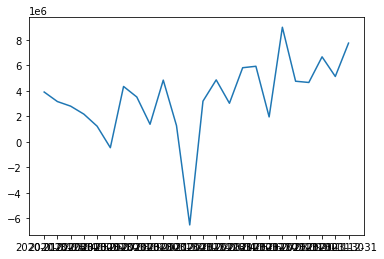

In [ ]:

values = series.expense_amount
# plot dataset
pyplot.plot(values)
pyplot.show()

In [ ]:

# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 


In [ ]:
df = pd.read_csv('./drive/MyDrive/Data/reu.csv', header=0, index_col=0)
train = df[12:] 

In [ ]:
train.head

<bound method NDFrame.head of             expense_amount
date                      
2020-01-31      3899020.74
2020-02-28      3152384.45
2020-03-31      2792221.64
2020-04-30      2166178.85
2020-05-31      1221850.70
2020-06-30      -463683.06
2020-07-31      4334905.98
2020-08-31      3509899.99
2020-09-30      1372597.60
2020-10-31      4831592.59
2020-11-30      1264795.96
2020-12-31     -6513874.90
2021-01-31      3182276.00
2021-02-28      4849701.48
2021-03-31      3019037.13
2021-04-30      5802868.26
2021-05-31      5916181.45
2021-06-30      1949195.95
2021-07-31      8974672.60
2021-08-31      4744777.67
2021-09-30      4647456.72
2021-10-31      6656905.80
2021-11-30      5117520.60
2021-12-31      7730533.50>

(24, 1)
>expected=4831592.6, predicted=1372597.2


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


>expected=1264796.0, predicted=4831587.0
>expected=-6513874.9, predicted=2174487.2
>expected=3182276.0, predicted=4336433.5
>expected=4849701.5, predicted=3524684.0
>expected=3019037.1, predicted=1255847.2
>expected=5802868.3, predicted=2238352.2
>expected=5916181.5, predicted=1264405.4
>expected=1949195.9, predicted=-6370904.5
>expected=8974672.6, predicted=3955709.0
>expected=4744777.7, predicted=6734101.5
>expected=4647456.7, predicted=8421140.0
>expected=6656905.8, predicted=7255255.5
>expected=5117520.6, predicted=5328448.5
>expected=7730533.5, predicted=4830912.5
MAE: 3398918.349


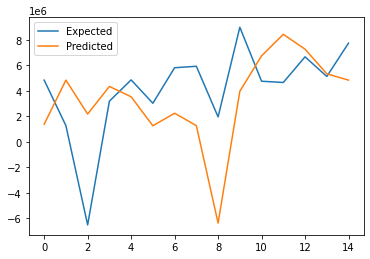

In [ ]:
# load the dataset
#./drive/MyDrive/Data/sentiment-tweets.csv
#series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0)
series = pd.read_csv('./drive/MyDrive/Data/reu.csv', header=0, index_col=0)
series = series[12:] 
values = series.values
print(values.shape)
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 15)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()



In [ ]:
# load the dataset
#series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0)
series = pd.read_csv('./drive/MyDrive/Data/reu.csv', header=0, index_col=0)
series = series[12:] 
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [8974672.6  4744777.67 4647456.72 6656905.8  5117520.6  7730533.5 ], Predicted: 6879462.500


PREDICTION

In [ ]:
predictions_xgb = reg.predict(X_test)
predictions_xgb = pd.DataFrame({'Predictions': \
                                     predictions_xgb})
result_xgb = pd.concat( \
                       [dataXGB.tail(len(X_test)) \
                               .reset_index(drop=True), \
                        predictions_xgb], axis=1)
print (result_xgb)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train.Month, train.Sales, label='Train')
plt.plot(test.Month, test.Sales, label='Test')
plt.plot(result_sarima.Month, result_sarima.Predictions, label='Prediction')
plt.xticks(df["Month"], df["Month"], rotation='vertical')
plt.legend(loc='best')
plt.title("Predictions by AutoRegressive (AR) model")
plt.show()

In [ ]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

In [ ]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [ ]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]